<a href="https://colab.research.google.com/github/gretaangolani/Algorithms-for-massive-data-DSE-/blob/main/FINDING_SIMILAR_ITEMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing apache spark, kaggle and download the dataset

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
%pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

import findspark
findspark.init("spark-3.5.0-bin-hadoop3")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

In [2]:
import pyspark
type(spark)

!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gretaangolani","key":"ec75a3d356fd7115de52b723b475e372"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets list

ref                                                                 title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                     DAIGT V2 Train Dataset                            29MB  2023-11-16 01:38:36           1756        178  1.0              
muhammadbinimran/housing-price-prediction-data                      Housing Price Prediction Data                    763KB  2023-11-21 17:56:32           7779        140  1.0              
jocelyndumlao/cardiovascular-disease-dataset                        Cardiovascular_Disease_Dataset                   411KB  2023-12-09 06:51:28           1062         48  1.0              
jeremylarcher/american-house-prices-and-demographics-of

In [5]:
!kaggle datasets download -d xhlulu/medal-emnlp

100% 6.81G/6.82G [01:24<00:00, 132MB/s]
100% 6.82G/6.82G [01:24<00:00, 86.9MB/s]


In [6]:
!unzip medal-emnlp.zip full_data.csv

Archive:  medal-emnlp.zip
  inflating: full_data.csv           


#Loading the data and first analysis

In [18]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer, StopWordsRemover
from pyspark.sql.functions import split, udf, explode, size, monotonically_increasing_id, max, regexp_replace
from pyspark.sql.types import ArrayType, StringType, IntegerType

# Starting Spark Session
spark = SparkSession.builder.appName("Similar_Items").getOrCreate()
df = spark.read.csv("full_data.csv", header=True)
df = df.select ('TEXT', 'LABEL').withColumn("doc_id", monotonically_increasing_id())
df_new = df.select('TEXT', 'doc_id')
df_new.show()

+--------------------+------+
|                TEXT|doc_id|
+--------------------+------+
|alphabisabolol ha...|     0|
|a report is given...|     1|
|the virostatic co...|     2|
|rmi rmi and rmi a...|     3|
|a doubleblind stu...|     4|
|stroma from eithe...|     5|
|the effect of the...|     6|
|in one experiment...|     7|
|the presence of a...|     8|
|the reaction of g...|     9|
|choline acetyltra...|    10|
|increasing concen...|    11|
|the properties of...|    12|
|primary amines re...|    13|
|a purification pr...|    14|
|dihydrofolate red...|    15|
|ionization effect...|    16|
|kinetic analyses ...|    17|
|the nearultraviol...|    18|
|the circular pola...|    19|
+--------------------+------+
only showing top 20 rows



In [19]:
df.count()

14393619

In [20]:
# Sample a subset of the original dataframe; I have uncommented each time the sample to analyze

#Sample1
#fraction = 50000.0 / df_new.count()
#subset_df = df_new.sample(withReplacement=False, fraction=fraction)

#Sample2
#fraction = 100000.0 / df_new.count()
#subset_df = df_new.sample(withReplacement=False, fraction=fraction)

#Sample3
#fraction = 150000.0 / df_new.count()
#subset_df = df_new.sample(withReplacement=False, fraction=fraction)

#Sample4
#fraction = 200000.0 / df_new.count()
#subset_df = df_new.sample(withReplacement=False, fraction=fraction)

#Sample5
fraction = 250000.0 / df_new.count()
subset_df = df_new.sample(withReplacement=False, fraction=fraction)

In [21]:
# Tokenization (using regex)
subset_df = subset_df.withColumn("processed_text", split(regexp_replace(subset_df["TEXT"], '[^\w\s]', ''), " "))

# Convert text to lowercase
@udf(ArrayType(StringType()))
def to_lowercase(text):
    return [word.lower() for word in text]

subset_df = subset_df.withColumn("processed_text", to_lowercase(subset_df["processed_text"]))

# Remove stop words
remover = StopWordsRemover(inputCol="processed_text", outputCol="filtered_text")
subset_df = remover.transform(subset_df)

subset_df.show()

+--------------------+------+--------------------+--------------------+
|                TEXT|doc_id|      processed_text|       filtered_text|
+--------------------+------+--------------------+--------------------+
|location of elect...|   188|[location, of, el...|[location, electr...|
|the proceedings o...|   324|[the, proceedings...|[proceedings, con...|
|the rates at whic...|   374|[the, rates, at, ...|[rates, pentobarb...|
|fiftyeight neurot...|   476|[fiftyeight, neur...|[fiftyeight, neur...|
|the metabolism of...|   482|[the, metabolism,...|[metabolism, cgri...|
|from a crude extr...|   516|[from, a, crude, ...|[crude, extract, ...|
|it was shown by g...|   517|[it, was, shown, ...|[shown, gel, elec...|
|beef kidney hydro...|   565|[beef, kidney, hy...|[beef, kidney, hy...|
|the observed stat...|   571|[the, observed, s...|[observed, static...|
|Arg and Met trans...|   608|[arg, and, met, t...|[arg, met, transp...|
|the injury due to...|   675|[the, injury, due...|[injury, due, 

#Applying Shingling, Minhashing and LSH

In [22]:
from pyspark.sql.functions import sort_array

k = 5

@udf(ArrayType(IntegerType()))
def shingling(text):
    return [hash(' '.join(text[i:i+k])) for i in range(len(text) - k + 1)]

subset_df = subset_df.withColumn("shingles", shingling(subset_df["filtered_text"]))
subset_df = subset_df.withColumn("sorted_shingles", sort_array(subset_df["shingles"]))
num_hashes = 100
hash_values = range(num_hashes)

@udf(ArrayType(IntegerType()))
def minhash_signature(sorted_shingles):
    signature = []
    for hash_val in hash_values:
        min_hash = float('inf')
        for shingle in sorted_shingles:
            hash_code = hash(f"{shingle}{hash_val}")
            min_hash = min(min_hash, hash_code)
        signature.append(min_hash)
    return signature

subset_df = subset_df.withColumn("minhash_signature", minhash_signature(subset_df["sorted_shingles"]))
subset_df.show()

+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                TEXT|doc_id|      processed_text|       filtered_text|            shingles|     sorted_shingles|   minhash_signature|
+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|location of elect...|   188|[location, of, el...|[location, electr...|[1767313138, 1172...|[-2117062463, -21...|[1951472397, -192...|
|the proceedings o...|   324|[the, proceedings...|[proceedings, con...|[-822431729, -192...|[-1953313038, -19...|[-1525146878, -14...|
|the rates at whic...|   374|[the, rates, at, ...|[rates, pentobarb...|[-240393048, 6317...|[-2077512425, -20...|[74547264, 147813...|
|fiftyeight neurot...|   476|[fiftyeight, neur...|[fiftyeight, neur...|[272697644, 37303...|[-2086144487, -20...|[1314311709, -987...|
|the metabolism of...|   482|[the, metabolism,...|[meta

In [23]:
b = 25
r = 4
assert b * r == num_hashes

@udf(ArrayType(IntegerType()))
def lsh_banding(minhash_signature):
    bands = [minhash_signature[i:i + r] for i in range(0, num_hashes, r)]
    bucket_ids = [hash("".join(map(str, band))) for band in bands]
    return bucket_ids

subset_df = subset_df.withColumn("buckets", lsh_banding(subset_df["minhash_signature"]))
subset_df.show()

+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                TEXT|doc_id|      processed_text|       filtered_text|            shingles|     sorted_shingles|   minhash_signature|             buckets|
+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|location of elect...|   188|[location, of, el...|[location, electr...|[1767313138, 1172...|[-2117062463, -21...|[1951472397, -192...|[-84402936, 34537...|
|the proceedings o...|   324|[the, proceedings...|[proceedings, con...|[-822431729, -192...|[-1953313038, -19...|[-1525146878, -14...|[-1908134915, 772...|
|the rates at whic...|   374|[the, rates, at, ...|[rates, pentobarb...|[-240393048, 6317...|[-2077512425, -20...|[74547264, 147813...|[-411020282, 2891...|
|fiftyeight neurot...|   476|[fiftyeight, neur...|[fiftyeight, n

#Jaccard Similarity and Label Analysis

In [24]:
from pyspark.sql.functions import array_distinct
from pyspark.sql.functions import collect_list

#Drop the same documents in the subset
subset_df = subset_df.dropDuplicates(['TEXT'])

# Explode subset_df
exploded_df = subset_df.withColumn("bucket", explode(subset_df["buckets"]))

# Group by bucket and collect the doc_ids
candidate_pairs = exploded_df.groupBy("bucket").agg(array_distinct(collect_list("doc_id")).alias("doc_ids"))

# Filter for buckets and take only the candidate pairs with more than one dec_ids
candidate_pairs = candidate_pairs.filter(size(candidate_pairs["doc_ids"]) > 1)

In [25]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StructType, StructField, FloatType, LongType
from itertools import combinations
import pyspark.sql.functions as F
import time
from pyspark.sql.functions import least, greatest


start_time = time.time()
# Define the schema for the output of the combinations UDF
schema = ArrayType(StructType([
    StructField("doc1", LongType(), False),
    StructField("doc2", LongType(), False)
]))


# Define the UDF for generating combinations
@udf(schema)
def combinations_udf(doc_ids):
    return [(int(doc1), int(doc2)) for doc1, doc2 in combinations(doc_ids, 2)]


# Define a UDF for Jaccard similarity
@udf(FloatType())
def jaccard_similarity_udf(doc1_shingles, doc2_shingles):
    set1 = set(doc1_shingles)
    set2 = set(doc2_shingles)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return float(intersection) / union if union != 0 else 0.0

threshold = 0.1
# Generate all pairs within each bucket
candidate_pairs = candidate_pairs.withColumn("doc_pair", explode(combinations_udf("doc_ids")))
candidate_pairs = candidate_pairs.withColumn(
    "min_doc_id",
    least(col("doc_pair.doc1"), col("doc_pair.doc2"))
).withColumn(
    "max_doc_id",
    greatest(col("doc_pair.doc1"), col("doc_pair.doc2"))
)

# Drop duplicates
candidate_pairs = candidate_pairs.dropDuplicates(["min_doc_id", "max_doc_id"])

# Join with 'subset_df' to get the shingles for each document in the pair
candidate_pairs = candidate_pairs.alias("cp").join(
    subset_df.alias("df1"),
    col("cp.doc_pair.doc1") == col("df1.doc_id")
).join(
    subset_df.alias("df2"),
    col("cp.doc_pair.doc2") == col("df2.doc_id")
)

# Calculate Jaccard similarity for each pair

similar_pairs_df = candidate_pairs.select(
    col("doc_pair.doc1"),
    col("doc_pair.doc2"),
    jaccard_similarity_udf(col("df1.sorted_shingles"), col("df2.sorted_shingles")).alias("similarity")
).filter(col("similarity") >= threshold)

In [26]:
similar_pairs_df.show()

end_time = time.time()

elapsed_time = (end_time - start_time)/60
print(f"Computation time: {elapsed_time:.2f} minutes")

+------------+------------+----------+
|        doc1|        doc2|similarity|
+------------+------------+----------+
|635655227678|566935719078| 0.3063063|
|420906916785|386547077846|0.28985506|
|360777328859|386547077846|       0.5|
|584115610772|523986041434| 0.4857143|
|953482788151|867583497018|0.35211268|
|549755856290|515396199416|0.51666665|
|360777328859|420906916785|0.31428573|
|773094128886|824633841832| 0.5825243|
+------------+------------+----------+

Computation time: 33.65 minutes


In [27]:
from pyspark.sql.functions import collect_set

start_time = time.time()
# Explode the labels for each document and alias the DataFrame
df_labels = df.withColumn("label", explode(split(col("LABEL"), "\|"))).alias("df_labels")

# Alias the similar_pairs_df
similar_pairs_alias = similar_pairs_df.alias("sp")

# Join to get labels for doc1 and doc2, then filter for shared labels
# Use "alias" to avoid ambiguous reference to doc_id
similar_pairs_with_shared_labels = (similar_pairs_alias
    .join(df_labels, col("sp.doc1") == col("df_labels.doc_id"))
    .join(df_labels.select(col("doc_id").alias("doc_id2"), col("label").alias("label2")), col("sp.doc2") == col("doc_id2"))
    .filter(col("df_labels.label") == col("label2"))
)

# Select distinct pairs and their shared label
distinct_pairs_with_labels = (similar_pairs_with_shared_labels
    .select(col("sp.doc1"), col("sp.doc2"), col("sp.similarity"), col("df_labels.label"))
    .distinct()
)

# Combine the sorting, grouping, and aggregation
combined_labels_df = (distinct_pairs_with_labels
                      .withColumn('doc_pair', F.array_sort(F.array('doc1', 'doc2')))
                      .groupBy('doc_pair')
                      .agg(
                          F.collect_list('label').alias('shared_labels'),
                          F.first('similarity').alias('similarity')
                      ))



In [28]:
combined_labels_df.show(truncate=False)

end_time = time.time()

elapsed_time = (end_time - start_time)/60
print(f"Computation time: {elapsed_time:.2f} minutes")

+----------------------------+--------------------+----------+
|doc_pair                    |shared_labels       |similarity|
+----------------------------+--------------------+----------+
|[523986041434, 584115610772]|[disease management]|0.4857143 |
|[360777328859, 420906916785]|[line, after]       |0.31428573|
|[867583497018, 953482788151]|[appropriate]       |0.35211268|
|[515396199416, 549755856290]|[electrophoresis]   |0.51666665|
+----------------------------+--------------------+----------+

Computation time: 39.38 minutes


In [36]:
pairs = [
    (360777328859, 386547077846, 0.5),
    (773094128886, 824633841832, 0.5825243),
    (360777328859, 420906916785, 0.31428573),
    (515396199416, 549755856290, 0.51666665)

]

for (doc_id1, doc_id2, similarity) in pairs:
    document_texts = df.filter((col("doc_id") == doc_id1) | (col("doc_id") == doc_id2))
    document_texts = document_texts.select("TEXT", "LABEL")

    print(f"Showing results for pair: {doc_id1}, {doc_id2} with similarity: {similarity}")
    document_texts.show(truncate=False)
    print("\n" + "-"*50 + "\n")

Showing results for pair: 360777328859, 386547077846 with similarity: 0.5
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+
|TEXT                                                                                                                                                                                                                                                                                                                                                                                                                                                 

#Plot the Graphs

In [29]:
import matplotlib.pyplot as plt

#Sample 1
subset_df1 = [50000.0/df.count()]
times_Jaccard1 = [12.74]
times_Label1 = [17.80]

#Sample2
subset_df2 = [100000.0/df.count()]
times_Jaccard2 = [18.53]
times_Label2 = [24.92]

#Sample3
subset_df3 = [150000.0/df.count()]
times_Jaccard3 = [23.22]
times_Label3 = [29.75]

#Sample4
subset_df4 = [200000.0/df.count()]
times_Jaccard4 = [28.83]
times_Label4 = [35.30]

#Sample5
subset_df5 = [250000.0/df.count()]
times_Jaccard5 = [33.65]
times_Label5 = [39.38]

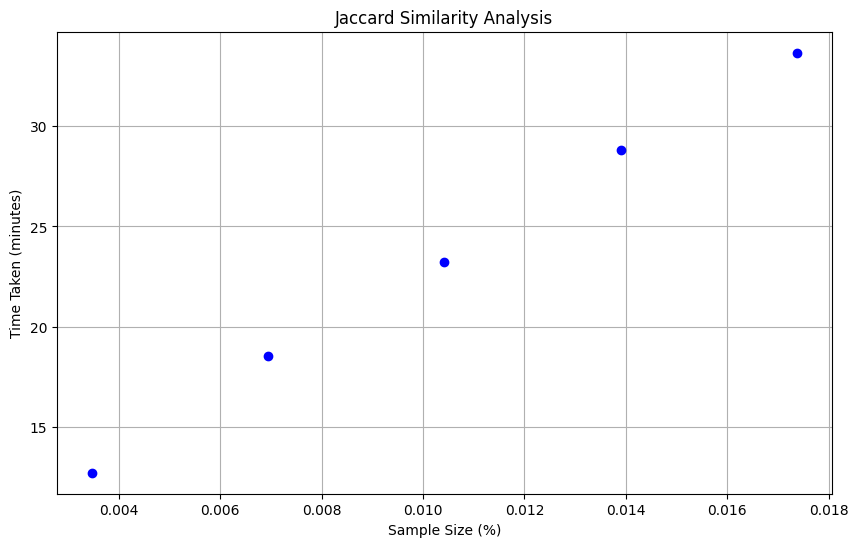

In [30]:
# Plot the graph for the Jaccard Similarity Analysis

plt.figure(figsize=(10, 6))
plt.plot(subset_df1, times_Jaccard1, subset_df2, times_Jaccard2,subset_df3, times_Jaccard3, subset_df4, times_Jaccard4, subset_df5, times_Jaccard5, marker='o', linestyle='-', color='b')  # Plot the data
plt.title('Jaccard Similarity Analysis')
plt.xlabel('Sample Size (%)')
plt.ylabel('Time Taken (minutes)')
plt.grid(True)
plt.show()

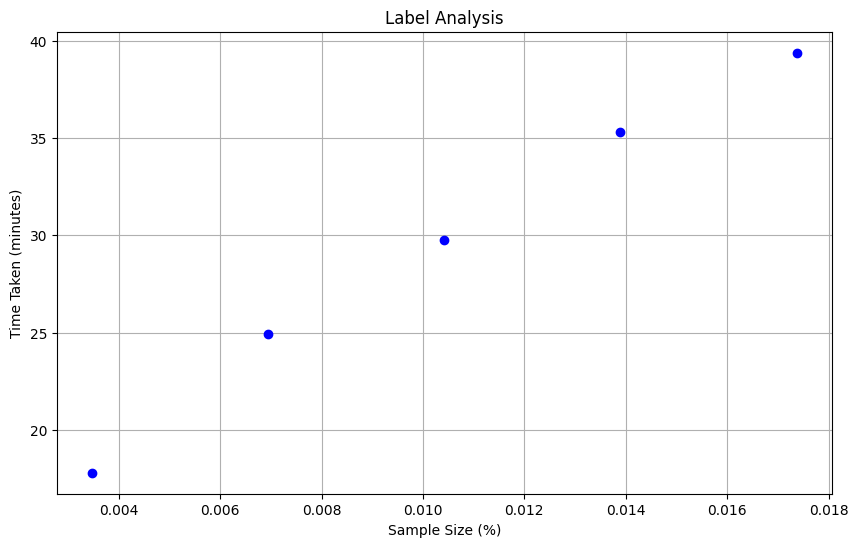

In [31]:
# Plot the graph for the Label Analysis

plt.figure(figsize=(10, 6))
plt.plot(subset_df1, times_Label1, subset_df2, times_Label2, subset_df3, times_Label3, subset_df4, times_Label4, subset_df5, times_Label5, marker='o', linestyle='-', color='b')  # Plot the data
plt.title('Label Analysis')
plt.xlabel('Sample Size (%)')
plt.ylabel('Time Taken (minutes)')
plt.grid(True)
plt.show()


#Stop spark session

In [37]:
spark.stop()